<a href="https://colab.research.google.com/github/ramtiin/Automated-Design-of-Symmetric-Autoencoders-Using-Genetic-Algorithms/blob/main/Automated_Design_of_Symmetric_Autoencoders_Using_Genetic_Algorithms.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Below is a summary of the study. For a more detailed analysis, please refer to the attached PDF file.**

## Abstract

This Notebook presents a novel approach for optimizing the architecture of symmetric, undercomplete autoencoders for dimensionality reduction using a genetic algorithm. The approach aims to find the optimal combination of the number of hidden layers, neurons per layer, activations, and optimizers for the autoencoder, with the goal of achieving good reconstruction quality as measured by the reconstruction loss. The proposed method is evaluated on a 16x16 MNIST dataset, and results show that the genetic algorithm-based approach is effective in finding suitable architectures for the autoencoder.

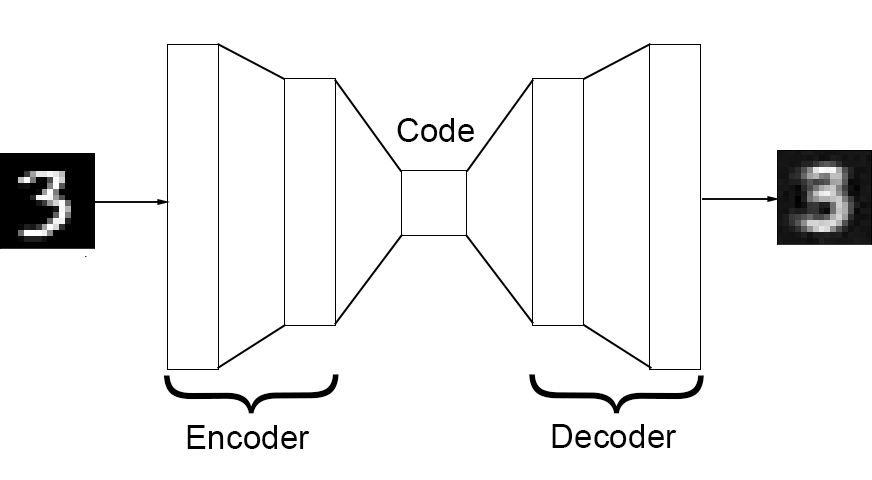

Figure 1: The general structure of an autoencoder. The encoder compresses the input data into a lower-dimensional latent space, and a symmetric decoder reconstructs the input data from the latent space. The network is undercomplete, meaning that the dimensionality of the latent space is smaller than the input data, resulting in data compression and reconstruction loss.

## Introduction

Autoencoders are a type of neural network that is commonly used for dimensionality reduction, feature extraction, anomaly detection, and data reconstruction. They consist of an encoder that maps the input to a lower-dimensional code, and a decoder that reconstructs the input from the code (Fig 1). In this research, I propose a genetic algorithm-based approach for optimizing the architecture of symmetric, undercomplete autoencoders for dimensionality reduction, with desired code size. Genetic algorithms are search algorithms inspired by natural selection processes and are commonly used for optimization problems. They work by iteratively generating and selecting a population of potential solutions, known as individuals or chromosomes. In the context of neural network design, genetic algorithms can be used to automatically search for the optimal architecture and hyperparameters of a model.

In my proposed approach, I have used a microbial genetic algorithm to search for the optimal architecture of symmetric autoencoders. The genotype, or genetic representation, of each individual in the population consists of the number of hidden layers, the number of neurons per layer, and the choice of activation and optimization functions. The fitness of each individual is determined by the reconstruction loss, which measures how well the input data is reconstructed 1 from the code. The genetic algorithm mutates, crosses over, and applies other biologically-inspired operators to find an optimal combination of these parameters for the autoencoder. The resulting autoencoder is expected to achieve good reconstruction quality, as measured by the reconstruction loss. 
The training and evaluation of the autoencoder are done on a 16x16 MNIST dataset, for increasing the training speed. In the end, I was able to find an optimal architecture, which can compress the MNIST data set to an array with a length of 4 and reconstruct the original data with a reasonable loss. 

Additionally, the proposed approach also allows for the specification of the desired code size, enabling the user to control the level of dimensionality reduction. This is particularly useful in applications where the amount of data reduction required is known in advance. Furthermore, the use of a symmetric architecture in the autoencoder ensures that the encoder and decoder have the same structure, making the model more robust and easier to train. 

In conclusion, the proposed approach of using a microbial genetic algorithm to optimize the architecture of symmetric, undercomplete autoencoders for dimensionality reduction, with desired code size, has been shown to be effective in finding optimal architectures that can achieve good reconstruction quality while reducing the dimensionality of the input data. This approach can be applied to other datasets and applications where dimensionality reduction is needed, making it a valuable tool for data preprocessing and analysis.

## Methodology


The methodology of this study involved the use of a microbial genetic algorithm to optimize the architecture of symmetric-undercomplete autoencoders for dimensionality reduction. The GA approach was chosen for its ability to effectively explore the large, complex design space of neural network architectures. First. I divide the data set into a training set and a validation set. The training set consisted of 10000 data points, while the validation set consisted of 5000 data points.

This division was done to speed up the training process. The fitness of each individual was determined by the reconstruction loss, which measures how well the input data is reconstructed from the code. The lower the reconstruction loss, the better the fitness of the individual.

The genetic algorithm then used biologically-inspired operators such as mutation, crossover, and selection to generate new individuals and improve the population over multiple generations. This process was repeated until a satisfactory solution was found or a predetermined number of generations had passed.

# Code

In [ ]:
import tensorflow as tf
import numpy as np
from tensorflow.keras.layers import Flatten,Dense,Input,Reshape
from tensorflow.keras.models import Sequential
from random import randrange

In [ ]:
(X_train, y_train) , (_, _) = tf.keras.datasets.mnist.load_data()


# expand new axis, channel axis 
X_train = np.expand_dims(X_train, axis=-1)

# it's always better to normalize 
X_train = X_train.astype('float32') / 255

# resize the input shape , i.e. old shape: 28, new shape: 16
X_train = tf.image.resize(X_train, [16,16]) # if we want to resize 

print(X_train.shape)
# (60000, 32, 32, 3)

(60000, 16, 16, 1)


In [ ]:
X_train = X_train[:, :, :,0]

In [ ]:
X_test = X_train[10000:15000]
X_train = X_train[0:10000]

In [ ]:
X_test.shape

TensorShape([5000, 16, 16])

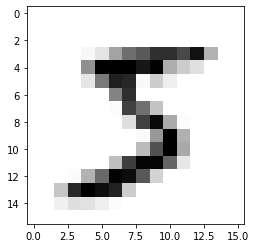

In [ ]:
import matplotlib
import matplotlib.pyplot as plt
plt.imshow(X_train[0], cmap=plt.cm.gray_r, interpolation="nearest")

In [ ]:
# DNA[0] = activations
# DNA[1] = optimizer
DNA_parameter = [["tanh","softmax","relu","sigmoid","linear"],
                 ["sgd","adam"]]

In [ ]:
class architecture:
    def __init__(self, neurons=None, activation=None, optimizer=None):
        self.neurons = neurons
        self.activation = activation
        self.optimizer = optimizer

In [ ]:
'''
This code defines a class called "Autoencoder" which inherits from the "Model" class from Tensorflow's Keras library.
The class has two main components: an encoder and a decoder, which are passed as arguments to the class constructor.
The class overrides the call() method, which takes an input x, and applies the encoder on it to get an encoded version of the input, and then applies the decoder on the encoded input to get the final decoded output.
'''

from tensorflow.keras.models import Model

class Autoencoder(Model):
  def __init__(self, encoder, decoder):
    super(Autoencoder, self).__init__()
    self.encoder = encoder
    self.decoder = decoder

  def call(self, x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return decoded

In [ ]:
'''
This code defines several functions related to creating and training autoencoders.
The first function, create_population(), creates a list of "architectures" which represent the different configurations of the autoencoder. It takes in 3 arguments: hidden_layers, DNA_parameter, population_size. It creates a list of architectures with random choices of activation functions, number of neurons per layer, optimizers.
The second function, mirror_model_architecture(), takes in an existing autoencoder model, and creates a mirrored version of that model (the decoder) by reversing the order of its layers.
The last function, create_model(), takes in an architecture, creates an encoder and a decoder for that architecture, creates an autoencoder by combining the encoder and decoder, and returns the autoencoder. The function creates the encoder by adding layers of dense units with random number of neurons, activation functions and optimizer. The decoder is created by reversing the layers of the encoder. The autoencoder is then compiled with a mean squared error loss function and optimizer.
'''

def create_population(hidden_layers,DNA_parameter,population_size=20):
  architectures=[]

  # unfold DNA_parameters:
  activations = DNA_parameter[0]
  optimizers = DNA_parameter[1]
  

  for pop in range(population_size):

    the_architecture=[]

    #We only need to create and optimize architecture for half of the depth of the network because we want to create symmetric autoencoders
    for i in range(hidden_layers):
        activation  = np.random.choice(activations)
        neurons_per_layer =  np.random.rand()
        the_architecture.append(architecture(neurons=neurons_per_layer,activation=activation))
    the_architecture.append(architecture(activation=np.random.choice(activations)))
    the_architecture.append(architecture(activation=np.random.choice(activations)))
    the_architecture.append(architecture(optimizer=np.random.choice(optimizers)))
    architectures.append(the_architecture)
  return architectures

def mirror_model_architecture(model):
  mirrored_model = tf.keras.models.Sequential()
  for layer in reversed(model.layers):
    mirrored_model.add(layer)
  return mirrored_model

def create_model(architecture,code_size):

        
    encoder = Sequential()
    encoder.add(tf.keras.Input(shape=(16,16)))
    encoder.add(Flatten())

    hidden_layers = (len(architecture)-3)
    
    actual_neurons = []
    actual_neurons.append(16*16)

    for i in range(1,hidden_layers):
      if i < hidden_layers:
        dense_units = round((architecture[i].neurons)*actual_neurons[i-1])

        if dense_units==0 or dense_units<code_size:
          actual_neurons.append(0)
          pass
        else:
          actual_neurons.append(dense_units)
          encoder.add(Dense(units=dense_units, activation = architecture[i].activation))
  
    encoder.add(Dense(units=code_size, activation = architecture[i].activation))
    decoder = Sequential()
    decoder_layers_list = []
    for i in range(len(encoder.layers)-2,0,-1):
      decoder_layers_list.append([encoder.layers[i].units,encoder.layers[i].activation])

    for layer in decoder_layers_list:
      decoder.add(Dense(units=layer[0], activation = layer[1]))
 
    decoder.add(Dense(units=16*16, activation = architecture[-2].activation))
    decoder.add(Reshape((16, 16)))
    autoencoder = Autoencoder(encoder, decoder)
    autoencoder.compile(optimizer=architecture[-1].optimizer, loss="mse")
    #autoencoder.build()
    return autoencoder

In [ ]:
#This line of code creates a list of "architectures" by calling the create_population() function. It specifies that the autoencoder should have 3 hidden layers, uses the DNA_parameter which is passed as an argument, and creates a population of 20 architectures. The returned list of architectures can be used to create autoencoder models using the create_model() function.
population = create_population(3,DNA_parameter,population_size=20)

In [ ]:
def train(model,epochs=2):
  return model.fit(X_train, X_train, 
          epochs=epochs, 
          batch_size=32,
          validation_data=(X_test, X_test),
          shuffle=True)
def fitness(loss):
  return loss[0] * -1

In [ ]:
#It's a way of displaying the architecture, so that it's easy to read and understand.
def print_architecture(architecture):
  lst=[]
  for arch in architecture:
    tmp=[]
    if arch.neurons!=None:
      tmp.append(arch.neurons)
    if arch.activation!=None:
      tmp.append(arch.activation)
    if arch.optimizer!=None:
      tmp.append(arch.optimizer)
    lst.append(tmp)
  print(lst)

In [ ]:
#This one shows the real numbers of neurons instead of percentage
def print_architecture_with_real_values(architecture):
  lst=[]
  neurons = [256]
  for arch in architecture:
    tmp=[]
    if arch.neurons!=None:
      tmp.append(round(neurons[-1]*arch.neurons))
      neurons.append(round(neurons[-1]*arch.neurons))
    if arch.activation!=None:
      tmp.append(arch.activation)
    if arch.optimizer!=None:
      tmp.append(arch.optimizer)
    lst.append(tmp)
  print(lst)

In [ ]:
'''
This function is implementing a Genetic Algorithm (GA) that uses the "population" of architectures to evolve the best architecture for an autoencoder. It takes several arguments like number of generations to run, code size, recombination rate, deme size, whether to use crossover and mutation or not.

For each generation, it selects two random architectures, creates models for them, trains them and calculate their fitness. The architecture with the higher fitness is chosen as the winner and the other one is the loser. Then it performs crossover and mutation on the loser based on the recombination rate and mutation rate. The new offspring is then added back to the population and the process is repeated.

The function also keeps track of the best fitness and best architecture found so far, and returns the best architecture and the best fitness over time. The function also uses the clear_session() method from Tensorflow to clear the session after each generation to prevent tensorflow from consuming too much memory.
'''


def GA(population,n_generations = 100,code_size=4,recombination_rate = 0.5,deme_size=5,Crossover=True,Mutation=True):

  mutation_rate = 1/len(population[0])
  best_fitness = -np.inf
  best_architecture = []
  pop_size = len(population)
  offspring_fitness_over_time = []

  activations = DNA_parameter[0]
  optimizers = DNA_parameter[1]

  for i in range(n_generations):
      print("Generation:",i)

      rand_genotype_1 = np.random.randint(0, pop_size)
      rand_genotype_2 = (rand_genotype_1+1+np.random.randint(0, deme_size))%pop_size



      P1= population[rand_genotype_1]
      P2= population[rand_genotype_2]

      
      P1_model = create_model(P1,code_size=code_size)
      P2_model = create_model(P2,code_size=code_size)
      

      his_1 = train(P1_model)
      his_2 = train(P2_model)

      fitness_P1 = fitness(his_1.history["loss"])
      fitness_P2 = fitness(his_2.history["loss"])

      if (fitness_P1>fitness_P2):
        Winner = P1
        Loser = P2
        Loser_idx = rand_genotype_2
      else:
        Winner = P2
        Loser = P1
        Loser_idx = rand_genotype_1


      print("Winner: ")
      print_architecture(Winner)
      print("Loser: ")
      print_architecture(Loser)
        

      for k in range(len(Loser)):
        if Crossover:
          if np.random.rand() < recombination_rate:
              Loser[k] = Winner[k]
        if Mutation:
          if np.random.rand() <1:
            if k<(len(Loser)-3):
              activation  = np.random.choice(activations)
              neurons = np.random.rand()
              Loser[k] = architecture(neurons=neurons,activation=activation)
            elif k>=(len(Loser)-3) and k!=len(Loser)-1:
              activation  = np.random.choice(activations)
              Loser[k] = architecture(activation=activation)
            else:
              optimizer =  np.random.choice(optimizers)
              Loser[k] = architecture(optimizer=optimizer)


      print("Child: ")
      print_architecture(Loser)
      


      population[Loser_idx] = Loser #Replacing the genotype in population

      offspring_model= create_model(Loser,code_size=code_size)
      his_offspring = train(offspring_model)
      offspring_fitness = fitness(his_offspring.history["loss"])


      if best_fitness < offspring_fitness:
        best_fitness = offspring_fitness
        best_architecture.append(Loser)
        print_architecture_with_real_values(best_architecture[-1])
        print(best_fitness)
      offspring_fitness_over_time.append(best_fitness)
      tf.keras.backend.clear_session()

      
      print("__________________")



  return offspring_fitness_over_time,best_architecture

In [ ]:
result,best_architecture = GA(population,n_generations=100)

Generation: 0
Epoch 1/2
313/313 [==============================] - 2s 4ms/step - loss: 0.2199 - val_loss: 0.2193
Epoch 2/2
313/313 [==============================] - 1s 4ms/step - loss: 0.2186 - val_loss: 0.2181
Epoch 1/2
313/313 [==============================] - 3s 7ms/step - loss: 0.1124 - val_loss: 0.0882
Epoch 2/2
313/313 [==============================] - 2s 7ms/step - loss: 0.0815 - val_loss: 0.0830
Winner: 
[[0.9775586135482421, 'sigmoid'], [0.8890705468421936, 'sigmoid'], [0.7349183850067187, 'relu'], ['tanh'], ['relu'], ['sgd']]
Loser: 
[[0.8301923458152872, 'relu'], [0.5029158962227244, 'relu'], [0.8179553648826428, 'linear'], ['relu'], ['sigmoid'], ['sgd']]
Child: 
[[0.10922897397984355, 'softmax'], [0.46413907021136735, 'linear'], [0.29905091241460025, 'sigmoid'], ['tanh'], ['sigmoid'], ['sgd']]
Epoch 1/2
313/313 [==============================] - 2s 4ms/step - loss: 0.2162 - val_loss: 0.2111
Epoch 2/2
313/313 [==============================] - 1s 4ms/step - loss: 0.2058 -

In [ ]:
'''
This code creates a final best autoencoder model using the last best architecture found from the GA function. It uses the create_model() function to create the model and passed in the best architecture and code size. Then it compiles the model with the optimizer and loss function (mean squared error) found in the best architecture. This final model can be trained and used for the specific task.
'''
best_model = create_model(best_architecture[-1],4)
best_model.compile(optimizer=best_architecture[-1][-1].optimizer, loss="mse")

In [ ]:
train(best_model,2)

Epoch 1/2
313/313 [==============================] - 2s 6ms/step - loss: 0.0410 - val_loss: 0.0340
Epoch 2/2
313/313 [==============================] - 2s 5ms/step - loss: 0.0314 - val_loss: 0.0315


In [ ]:
encoded_imgs = best_model.encoder(X_test).numpy()
decoded_imgs = best_model.decoder(encoded_imgs).numpy()

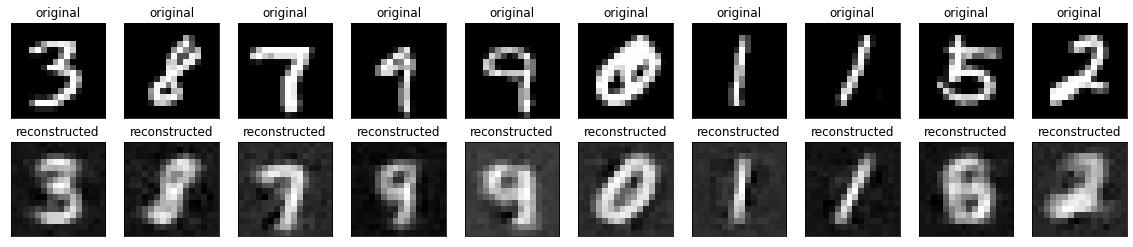

In [ ]:
#This code is used to display the original and decoded images side by side.
n = 10
plt.figure(figsize=(20, 4))
for i in range(n):
  # display original
  ax = plt.subplot(2, n, i + 1)
  plt.imshow(X_test[i])
  plt.title("original")
  plt.gray()
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)

  # display reconstruction
  ax = plt.subplot(2, n, i + 1 + n)
  plt.imshow(decoded_imgs[i])
  plt.title("reconstructed")
  plt.gray()
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)
plt.show()

In [ ]:
print_architecture_with_real_values(best_architecture[-1])

[[38, 'softmax'], [25, 'relu'], [11, 'linear'], ['softmax'], ['tanh'], ['adam']]


In [ ]:
print_architecture(best_architecture[-1])

[[0.14648538118669685, 'softmax'], [0.6489160368156419, 'relu'], [0.43646250883541826, 'linear'], ['softmax'], ['tanh'], ['adam']]


In [ ]:
#This function is used to plot the fitness of the best offspring over the generations of the GA algorithm. 
from matplotlib import pyplot as plt
def plot(offspring_fitness_over_time):
  plt.figure(figsize=(8, 6), dpi=80)
  plt.plot(result)
  plt.xlabel("Generations")
  plt.ylabel("Fitness")
  plt.plot()

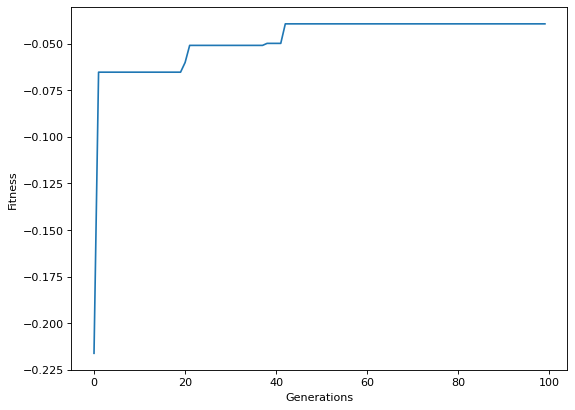

In [ ]:
plot(result)